## Applications

This is our last workshop, so first I'd like to thank you all for sticking through it and making it through the semester. Today we're going to talk about a subject near and dear to the hearts of many Harvard students, which is applying data science in finance. 

## Time series analysis
Analyzing stock price data is usually a task for time series analysis, as you probably already know. Let's get some of that data now

In [3]:
import datetime as dt
import matplotlib.pyplot as plt 
import numpy as np 
import numpy.linalg as la 
import pandas as pd
import scipy.cluster.hierarchy as sch
import seaborn as sns
from pandas.io.data import DataReader
from scipy.stats import mode 
from scipy.stats.stats import pearsonr
from IPython.display import Image
%matplotlib inline

# first we need a list of the tickers on the S&P 500 so that we can query Yahoo for that data
tickerdf = pd.read_csv('constituents.csv')
tickers = list(tickerdf['Symbol'].values)
start_date = dt.datetime(2012, 1, 1)

print(tickers[:5])

ticker_df_list = []
for ticker in tickers: 
    try:
        r = DataReader(ticker, "yahoo", start=start_date)   # download price data from yahoo 
        r['Ticker'] = ticker 
        ticker_df_list.append(r) 
    except:
        print "couldn't find data for {}".format(ticker)

df = pd.concat(ticker_df_list)
cell= df[['Ticker','Adj Close']]
cell.reset_index().sort(['Ticker', 'Date'], ascending=[1,0]).set_index('Ticker')
cell.to_pickle('close_price.pkl')

['MMM', 'ABT', 'ABBV', 'ACN', 'ATVI']


But let's try understanding how this data might come to be. For a stock price, we might assume that there are random movements up and down, so maybe if we look at the difference in stock price between timestamps, it might be distributed as a 0-centered random variable. But what kind of random variable? Usually our go to in statistics is to start with a normal distribution, since we understand it's properties, but in this case we can empirically find that the distribution has heavier tails (i.e. more probability mass farther away from 0) than a normal distribution. So, maybe it can be generated via a [Student's t-distribution](https://en.wikipedia.org/wiki/Student's_t-distribution). Let's try looking at what the data would look like in that case:

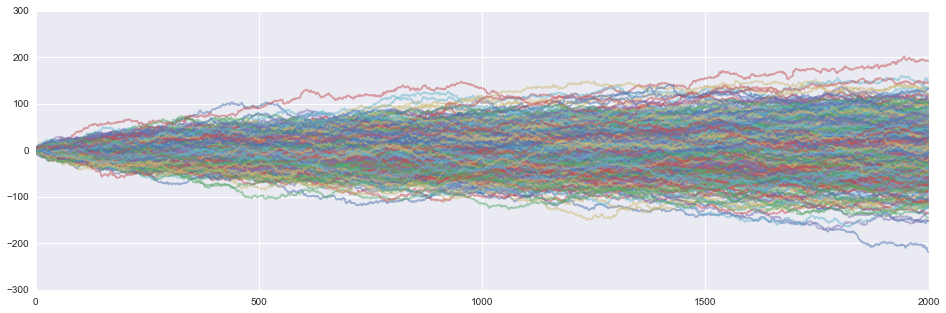

(array([   1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    1.,    0.,    0.,    0.,    2.,    0.,    1.,
           0.,    1.,    0.,    1.,    4.,    9.,   12.,   29.,   37.,
          63.,   71.,   94.,  127.,  205.,  226.,  260.,  225.,  184.,
         143.,  110.,   61.,   38.,   37.,   20.,   14.,    6.,    4.,
           4.,    2.,    3.,    2.,    3.]),
 array([-10.57885427, -10.2634354 ,  -9.94801653,  -9.63259766,
         -9.31717878,  -9.00175991,  -8.68634104,  -8.37092217,
         -8.0555033 ,  -7.74008443,  -7.42466556,  -7.10924669,
         -6.79382782,  -6.47840895,  -6.16299008,  -5.84757121,
         -5.53215234,  -5.21673346,  -4.90131459,  -4.58589572,
         -4.27047685,  -3.95505798,  -3.63963911,  -3.32422024,
         -3.00880137,  -2.6933825 ,  -2.37796363,  -2.06254476,
         -1.74712589,  -1.43170701,  -1.11628814,  -0.80086927,
         -0.4854504 ,  -0.17003153,   0.14538734,   0.46080621,
          0.77622508,   

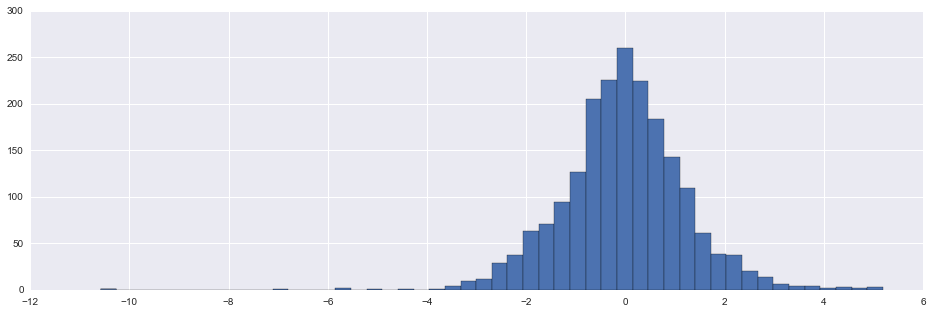

In [5]:
# generate 500 stocks, each with 2000 sampled changes (let's assume they all start at 0)
rpaths = np.random.standard_t(5, size=(2000,500))  # generate paths

# the cumulative sums plotted (i.e. the stock over time)
plt.figure(figsize=(16,5))                                         
plt.plot(rpaths.cumsum(axis=0),alpha=0.5)
plt.show()

# the actual values sampled from the t-distribution
plt.figure(figsize=(16,5))
plt.hist(rpaths.T[1],bins=50)

One of the usual tricks with time series is to look at the matrix of *correlations* of the series, and in particular one way to look at matrices is to look at their spectral distribution, or their eigenvalues:

(array([  7.,  15.,  16.,  16.,  17.,  17.,  15.,  17.,  17.,  16.,  15.,
         15.,  15.,  13.,  14.,  15.,  12.,  13.,  13.,  11.,  11.,  13.,
         11.,  10.,  12.,   9.,  10.,   9.,  10.,   9.,   8.,   8.,   7.,
          8.,   8.,   7.,   5.,   8.,   6.,   6.,   4.,   5.,   6.,   4.,
          4.,   3.,   3.,   3.,   3.,   1.]),
 array([ 0.24891019,  0.28863775,  0.32836531,  0.36809287,  0.40782044,
         0.447548  ,  0.48727556,  0.52700312,  0.56673069,  0.60645825,
         0.64618581,  0.68591337,  0.72564093,  0.7653685 ,  0.80509606,
         0.84482362,  0.88455118,  0.92427875,  0.96400631,  1.00373387,
         1.04346143,  1.08318899,  1.12291656,  1.16264412,  1.20237168,
         1.24209924,  1.28182681,  1.32155437,  1.36128193,  1.40100949,
         1.44073706,  1.48046462,  1.52019218,  1.55991974,  1.5996473 ,
         1.63937487,  1.67910243,  1.71882999,  1.75855755,  1.79828512,
         1.83801268,  1.87774024,  1.9174678 ,  1.95719536,  1.99692293,
 

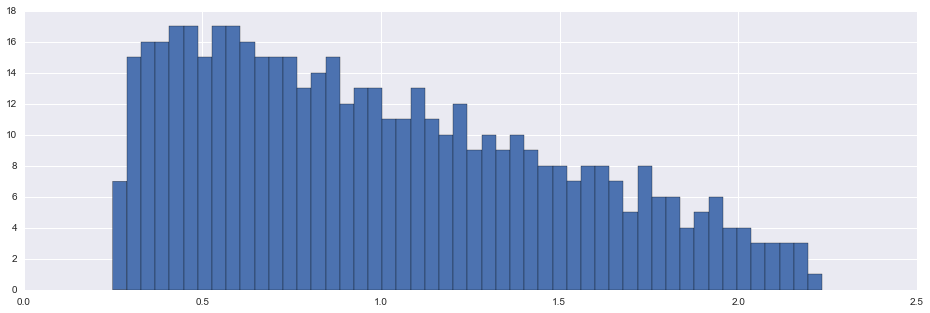

In [6]:
evalplot = la.eig(pd.DataFrame(rpaths).corr())[0]
plt.figure(figsize=(16,5))
plt.hist(evalplot,bins=50)

So the eigenvalues seem to have a distribution: 0 before 0.25, increasing sharply, and then tailing off to 0 around 2.25. In fact, there's a theorem that tells us what the distribution of eigenvalues will look like:

#### Theorem (Marchenko & Pastur)
Let $X$ be a random $n \times r$ matrix whose i.i.d. entries have finite variance. Then the eigenvalues of the correlation matrix of $X$ are distributed as:
$$f(\lambda) = \frac{q}{2\pi\lambda}\sqrt{(\lambda_+ - \lambda)(\lambda - \lambda_-)}$$
where 
$$\lambda_{\pm} = 1 + \frac{1}{q} + 2\sqrt{\frac{1}{q}}$$ and $q = n/r$. 

Let's plot this function:

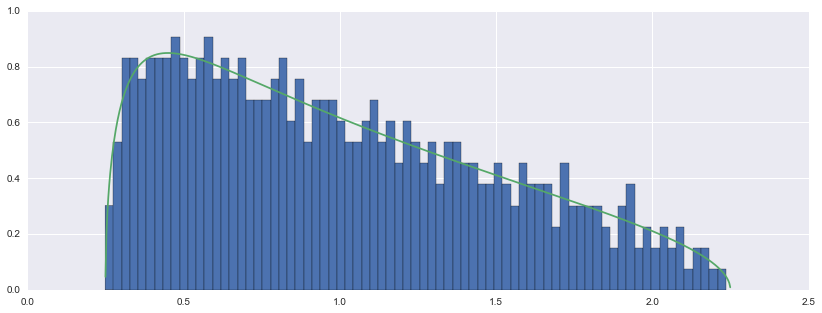

In [9]:
# density distribution
def eigden(lam,n,r):
    q = float(n)/r
    lplus = 1+1/q+2*np.sqrt(1/q)
    lminus = 1+1/q-2*np.sqrt(1/q)
    return q/(2*np.pi*lam)*np.sqrt((lplus-lam)*(lam-lminus))

lamvls = np.linspace(0.001,3,1000) 
plt.figure(figsize=(14,5))
plt.hist(evalplot,bins=75,normed=True)
plt.plot(lamvls,[eigden(lam,2000,500) for lam in lamvls])
plt.show()

Nice! Turns out Marchenko and Pastur were right. Note that the theorem doesn't assume anything about the distribution of the entries in $X$ other than that it has finite variance.

#### Plan of Attack
Ok, if we want to reduce the noise of our time series (to understand the signal), we can replace the eigenvalues in our correlation matrix (from our real, Yahoo data) with the mean of the mean from the Marchenko/Pastur distribution, and use that to create a new correlation matrix. Then we can search over all positive semidefinite symmetric matrices (well, technically those with 1s in the main diagonal since that's what a correlation matrix looks like) to find the closes one.

How do we measure closeness between two matrices? We can use a metric called the [*Frobenius norm*](https://en.wikipedia.org/wiki/Matrix_norm#Frobenius_norm), which is the square root of sum of the squares of the elementwise differences between the two matrices. In essence, if the matrices are [[1, 2], [3, 4]] and [[5, 6],[7, 8]], then the Frobenius norm is:
$$\sqrt{4^2 + 4^2 + 4^2 + 4^2}$$

How do we do this search? Luckily since we're working with Python someone has written the code to do it for us (which works essentially via gradient descent). Let's import it now.

In [10]:
from nearest_correlation import nearcorr

In [ ]:
def lamplus(n,r): 
    '''
    Upper eigenvalue limit of the Marchenko Pastur density 
    '''
    q = float(n)/float(r)
    return (1+1/q+2*np.sqrt(1/q))

# Read in closing price data if it is not already a local variable
if 'cell' not in locals():
    df = pd.read_pickle('close_price.pkl')
else: 
    df = cell 
    
dte1 = '2010-07-01'
dte2 = '2015-07-01'
tickers = sorted(list(set(df['Ticker'].values)))                   # sorted list of unique tickers  
tkrlens = [len(df[df.Ticker==tkr][dte1:dte2]) for tkr in tickers]  # find lengths of times series for each ticker 
tkrmode = mode(tkrlens)[0][0]                                      # find mode of time series lengths 

# idenfity tickers whose lenghts equal the mode and call these good tickers
good_tickers = [tickers[i] for i,tkr in enumerate(tkrlens) if tkrlens[i]==tkrmode]  

rtndf = pd.DataFrame()  # initialize a return dataframe

# Normalize all time series to have mean zero and variance one and compute their returns 
for tkr in good_tickers: 
    tmpdf = df[df.Ticker==tkr]['Adj Close'][dte1:dte2]
    tmprtndf = ((tmpdf-tmpdf.shift(1))/tmpdf).dropna()
    rsdf = (tmprtndf-tmprtndf.mean())/tmprtndf.std()
    rtndf = pd.concat([rtndf, rsdf],axis=1)

rtndf = rtndf.dropna()
rtndf.columns = good_tickers
t,m = rtndf.shape
cmat = rtndf.corr()                                           # compute correlation matrix 
evls, evcs = la.eig(cmat)                                     # compute eigenvalue/vector decomposition of matrix 
evallst = map(abs,evls)                                       # take abs of evals (very small imag parts)
filtvals = [val for val in evallst if val < lamplus(t,m)]     # filter eigenvalues 
sevlist = [np.mean(filtvals)]*len(filtvals)                 
feval = evallst[:(len(evallst)-len(sevlist))] + sevlist       # build list of new eigenvalues
rcmat = abs(np.dot(np.dot(evcs,np.diag(feval)),la.inv(evcs))) # reconstruct candidate correlation matrix 
rcmat = (rcmat + rcmat.T)/2                                   # symmetrize the candidate matrix 
ncorr = nearcorr(rcmat, max_iterations=1000)                  # find nearest correlation matrix 
ncorrdf = pd.DataFrame(ncorr,columns=good_tickers,index=good_tickers)

### Finishing up and viewing the work

now we have `ncorrdf`, which is the dataframe containing the filtered correlation matrix. Let's take a look at it:

### References
Bouchaud and Potters: Financial Applications of Random Matrix Theory (a short review) http://arxiv.org/pdf/0910.1205.pdf